In [7]:
#Libraries 

import pandas as pd
import os
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


In [8]:
# Configurar visualização

%matplotlib inline
sns.set_theme(style="whitegrid")

In [10]:
# Pega o caminho da pasta onde o notebook está salvo
diretorio_atual = os.getcwd()
path = os.path.join(diretorio_atual, 'kc_house_data.csv')

# Tenta carregar
try:
    df = pd.read_csv(path, sep=',') 
    print("Sucesso! O arquivo foi encontrado.")
    display(df.head())
except FileNotFoundError:
    print(f"Erro: O arquivo não está em {path}")
    print("Arquivos encontrados nesta pasta:", os.listdir(diretorio_atual))

Sucesso! O arquivo foi encontrado.


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


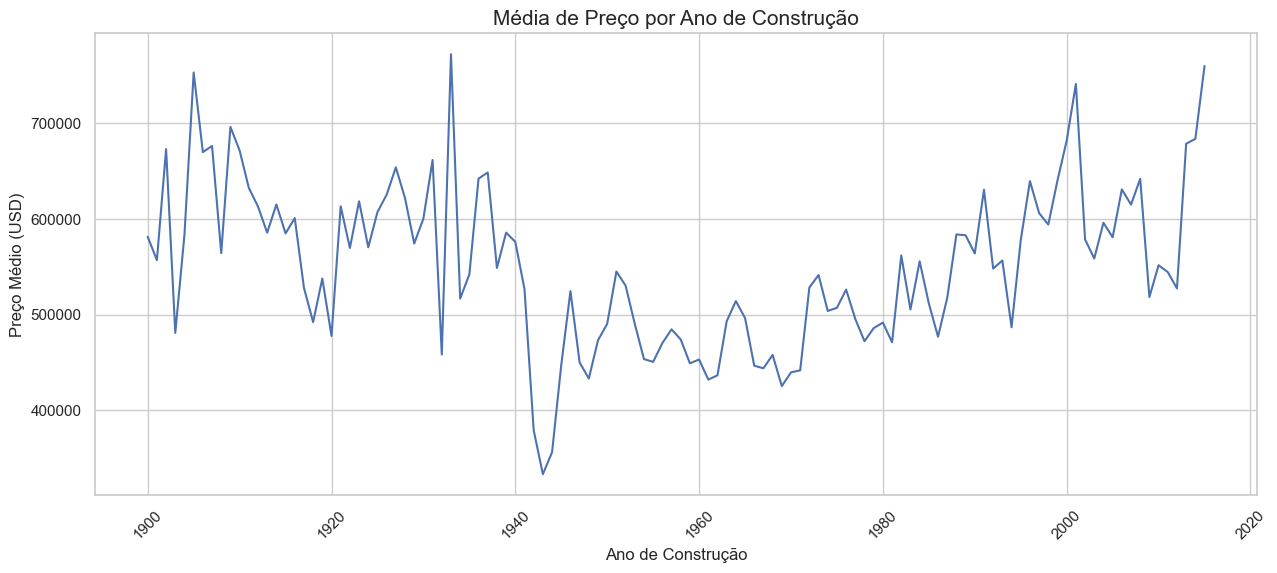

In [11]:
# Agrupamento por ano de construção

df_year = data[['price', 'yr_built']].groupby('yr_built').mean().reset_index()

# Plotagem
plt.figure(figsize=(15, 6))
sns.lineplot(x='yr_built', y='price', data=df_year)

plt.title('Média de Preço por Ano de Construção', fontsize=15)
plt.xlabel('Ano de Construção')
plt.ylabel('Preço Médio (USD)')
plt.xticks(rotation=45)
plt.show() 

In [12]:
# 1. Preço por metro quadrado

data['price_per_sqft'] = data['price'] / data['sqft_living']

# 2. Preço médio por CEP (zipcode)

avg_price_zip = data.groupby('zipcode')['price'].mean().reset_index()
avg_price_zip.rename(columns={'price': 'avg_price_zip'}, inplace=True)
data = pd.merge(data, avg_price_zip, on='zipcode', how='left')

# 3. Índice de Valor (Localização valorizada / Preço por m2 barato)

data['value_score'] = data['avg_price_zip'] / data['price_per_sqft']

# Mostrar as 10 melhores oportunidades

top_oportunidades = data.sort_values(by='value_score', ascending=False).head(10)
print("Top 10 Casas com melhor custo-benefício (Localização vs Preço):")
display(top_oportunidades[['id', 'price', 'zipcode', 'value_score']])

Top 10 Casas com melhor custo-benefício (Localização vs Preço):


,id,price,zipcode,value_score
21372,6169901185,490000.0,98119,7731.710516
326,3530210260,274975.0,98077,7523.621721
3721,5451100490,884900.0,98040,7247.163763
16931,5016002275,610000.0,98112,7165.643237
1763,1832100030,597326.0,98040,7137.477987
1222,1238500451,130000.0,98033,6862.528236
21050,2424059170,900000.0,98006,6801.061808
9216,1825079018,340000.0,98053,6781.630593
14835,3613600150,300523.0,98119,6698.960807
9417,9828701565,375000.0,98112,6543.782736


In [13]:
# Inicializa API com identificador único

geolocator = Nominatim(user_agent='house_rocket_explorer')
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1.1)

# Amostra das 20 primeiras linhas para teste

df_sample = data.head(20).copy()

print("Iniciando geocodificação reversa... Aguarde.")

def get_address(row):
    try:
        query = f"{row['lat']}, {row['long']}"
        location = reverse(query)
        if location and 'address' in location.raw:
            addr = location.raw['address']
            return pd.Series([
                addr.get('road', 'NA'),
                addr.get('house_number', 'NA'),
                addr.get('city', 'NA'),
                addr.get('state', 'NA')
            ])
    except:
        return pd.Series(['Erro', 'Erro', 'Erro', 'Erro'])

# Aplica a função

df_sample[['road', 'house_number', 'city', 'state']] = df_sample.apply(get_address, axis=1)

print("Processo concluído!")
display(df_sample[['id', 'lat', 'long', 'road', 'city', 'state']])

Iniciando geocodificação reversa... Aguarde.
Processo concluído!


,id,lat,long,road,city,state
0,7129300520,47.5112,-122.257,61st Avenue South,Seattle,Washington
1,6414100192,47.7210,-122.319,Northeast 127th Street,Seattle,Washington
2,5631500400,47.7379,-122.233,81st Avenue Northeast,NA,Washington
3,2487200875,47.5208,-122.393,Fauntleroy Way Southwest,Seattle,Washington
4,1954400510,47.6168,-122.045,221st Avenue Northeast,NA,Washington
5,7237550310,47.6561,-122.005,Northeast Patterson Way,NA,Washington
6,1321400060,47.3097,-122.327,South 330th Place,Federal Way,Washington
7,2008000270,47.4095,-122.315,14th Avenue South,NA,Washington
8,2414600126,47.5123,-122.337,Southwest 102nd Street,Seattle,Washington
9,3793500160,47.3684,-122.031,232nd Place Southeast,NA,Washington
